Classes e cores:
                 name    r    g    b
0              Animal   64  128   64
1             Archway  192    0  128
2           Bicyclist    0  128  192
3              Bridge    0  128   64
4            Building  128    0    0
5                 Car   64    0  128
6     CartLuggagePram   64    0  192
7               Child  192  128   64
8         Column_Pole  192  192  128
9               Fence   64   64  128
10       LaneMkgsDriv  128    0  192
11    LaneMkgsNonDriv  192    0   64
12          Misc_Text  128  128   64
13  MotorcycleScooter  192    0  192
14        OtherMoving  128   64   64
15       ParkingBlock   64  192  128
16         Pedestrian   64   64    0
17               Road  128   64  128
18       RoadShoulder  128  128  192
19           Sidewalk    0    0  192
20         SignSymbol  192  128  128
21                Sky  128  128  128
22     SUVPickupTruck   64  128  192
23        TrafficCone    0    0   64
24       TrafficLight    0   64   64
25              Train

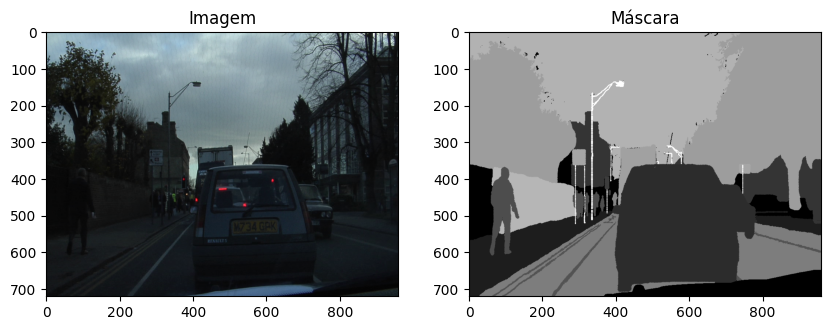

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Diretório do dataset CamVid
dataset_dir = 'CamVid'

# Caminhos das pastas
train_dir = os.path.join(dataset_dir, 'train')
train_labels_dir = os.path.join(dataset_dir, 'train_labels')
val_dir = os.path.join(dataset_dir, 'val')
val_labels_dir = os.path.join(dataset_dir, 'val_labels')
test_dir = os.path.join(dataset_dir, 'test')
test_labels_dir = os.path.join(dataset_dir, 'test_labels')

# Carregar o arquivo de dicionário de classes
class_dict_path = os.path.join(dataset_dir, 'class_dict.csv')
class_dict = pd.read_csv(class_dict_path)

# Exibir as classes e cores
print("Classes e cores:")
print(class_dict)

# Função para mostrar uma imagem e sua máscara
def display_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Imagem")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Máscara")
    plt.show()

# Exemplo de visualização
sample_image_path = os.path.join(train_dir, os.listdir(train_dir)[0])
sample_mask_path = os.path.join(train_labels_dir, os.listdir(train_labels_dir)[0])
display_image_and_mask(sample_image_path, sample_mask_path)


# Pré-processamento das Imagens e Máscaras

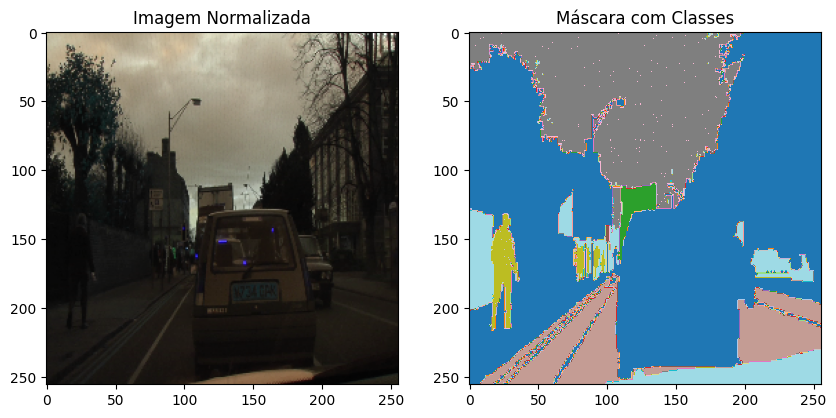

In [7]:
import numpy as np

# Definindo o tamanho das imagens para redimensionamento
IMAGE_SIZE = (256, 256)

# Mapeamento de cores para IDs das classes
def create_label_map(class_dict):
    color_map = {}
    for i, row in class_dict.iterrows():
        color = tuple(int(x) for x in row[["r", "g", "b"]])
        color_map[color] = i  # Cada cor mapeada para um índice de classe
    return color_map

color_map = create_label_map(class_dict)

# Função para redimensionar imagens e converter máscaras
def preprocess_image_and_mask(image_path, mask_path, image_size):
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size) / 255.0  # Normalização para [0, 1]
    
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
    
    # Converte a máscara para rótulos de classe
    mask_labels = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)
    for color, label in color_map.items():
        mask_labels[(mask == color).all(axis=2)] = label

    return image, mask_labels

# Exemplo de pré-processamento
sample_image, sample_mask = preprocess_image_and_mask(sample_image_path, sample_mask_path, IMAGE_SIZE)

# Exibir a imagem e a máscara pré-processada
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Imagem Normalizada")
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='tab20')
plt.title("Máscara com Classes")
plt.show()


# Organização dos Dados para Treinamento

In [9]:
import tensorflow as tf 
from tensorflow.keras.utils import Sequence

class CamVidDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, image_size, color_map):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.color_map = color_map
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        # Selecionar lote de imagens e máscaras
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Pré-processar o lote
        images = []
        masks = []
        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            img, mask = preprocess_image_and_mask(img_path, mask_path, self.image_size)
            images.append(img)
            masks.append(mask)
        
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        # Shuffle (embaralhar) os dados a cada época para evitar overfitting
        data = list(zip(self.image_paths, self.mask_paths))
        np.random.shuffle(data)
        self.image_paths, self.mask_paths = zip(*data)

# Caminhos das imagens e máscaras de cada conjunto
train_images = [os.path.join(train_dir, img) for img in os.listdir(train_dir)]
train_masks = [os.path.join(train_labels_dir, img) for img in os.listdir(train_labels_dir)]
val_images = [os.path.join(val_dir, img) for img in os.listdir(val_dir)]
val_masks = [os.path.join(val_labels_dir, img) for img in os.listdir(val_labels_dir)]
test_images = [os.path.join(test_dir, img) for img in os.listdir(test_dir)]
test_masks = [os.path.join(test_labels_dir, img) for img in os.listdir(test_labels_dir)]

# Definindo parâmetros de batch e geradores de dados
BATCH_SIZE = 8
train_generator = CamVidDataGenerator(train_images, train_masks, BATCH_SIZE, IMAGE_SIZE, color_map)
val_generator = CamVidDataGenerator(val_images, val_masks, BATCH_SIZE, IMAGE_SIZE, color_map)


Construção do Modelo de Segmentação

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 3), num_classes=len(class_dict)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │    131,200 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_8[0][0]  

 Total params: 1,864,864 (7.11 MB)

 Trainable params: 1,864,864 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

# Treinamento do Modelo

In [ ]:
# Número de épocas de treinamento
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)


c:\Users\Thaleson\camvim_project\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


c:\Users\Thaleson\camvim_project\venv\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


37/46 ━━━━━━━━━━━━━━━━━━━━ 4:26 30s/step - accuracy: 0.3544 - loss: 2.2587